# DSC 200 Final project

This project analyzes climate projections of temperature changes across the Earth under a 'middle-of-the-road' future scenario, where global mean temperatures are expected to rise by more than 2°C above pre-industrial levels. The goal of this project is to read, analyze, and visualize data using various techniques, as well as to create a small command-line interface for interactive analysis.

### Table of Contents:

1. [CO2 Emissions Data: Historical and Future Scenarios](#1.-co2-emissions-data-historical-and-future-scenarios)  
   In this section, I will read in and analyze data on historical and future CO2 emissions.  

2. [Temperature Data Analysis](#2.-temperature-data-analysis)  
   This section focuses on reading and processing temperature data to understand global warming trends.  

3. [Building a Simple Regression Model for Global Warming](#3.-building-a-simple-regression-model-for-global-warming)  
   A basic regression model is created to predict global temperature changes based on emissions data.  

4. [Extending the Model to Regional Temperature Predictions](#4.-extending-the-model-to-regional-temperature-predictions)  
   The regression model is extended to predict temperature changes by region and state.  

5. [Visualizing Regression Coefficients for Each Country](#5.-visualizing-regression-coefficients-for-each-country)  
   In this section, I will plot the regression coefficients to better understand how temperature change varies across countries.  

6. [Custom Analysis](#6.-custom-analysis)  
   This section presents a unique analysis of my choice, offering further insights into the data.  

7. [Command-Line Interface for Prediction](#7.-command-line-interface-for-prediction)  
   I developed a command-line interface that allows users to interactively predict temperature changes based on the model.

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## 1. Reading historical and future (estimated) CO2 emissions data

This section focuses on analyzing monthly CO2 emissions data, which has been recorded globally since 1850 across various industrial sectors. For the purposes of this project, I use the annual average totals of emissions from all sectors. Given CO2's long atmospheric lifetime (thousands of years), I assume that the cumulative sum of all emissions since 1850 represents the total anthropogenic CO2 present in the atmosphere. This cumulative value will be the foundation for the analysis.

I explored different approaches for reading and processing this emissions data to ensure accurate modeling and further analysis.

In [35]:
input_path = 'FinalProject/'

### 1a. OPTIONAL: Create interpolated cumalitve CO2 from the raw data using Pandas

In this step, I used Pandas to create a new column in the CO2 emissions dataset that represents the cumulative CO2 emissions over time. This allows for a clearer understanding of how CO2 has accumulated in the atmosphere since 1850, offering valuable insights for further analysis. By interpolating the data, we can fill any gaps and ensure the dataset is complete for accurate modeling.

In [36]:
# These input files provide CO2 emissions data for the historical period (1850-2014) and the future period (2015-2100). 
historical_input_files = ['CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_195001-199912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_190001-194912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185101-189912.csv']

future_input_file = 'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.csv'

Concatenating Historic and Future files:

In [37]:
#read the input files

# Loop through the historic file paths and read each file into a pandas dataframe
dfs = []

for file_path in historical_input_files:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Reading and appending the future data
future_df = pd.read_csv(future_input_file)
dfs.append(future_df)
    
# Concatenate all dataframes
concatenated_df = pd.concat(dfs, ignore_index=True)

# Display the concatenated dataframe
concatenated_df

,year,em,sector,month,global_total,units
0,2000,CO2,AGR,1,0.000000,kt
1,2000,CO2,AGR,2,0.000000,kt
2,2000,CO2,AGR,3,0.000000,kt
3,2000,CO2,AGR,4,0.000000,kt
4,2000,CO2,AGR,5,0.000000,kt
...,...,...,...,...,...,...
16819,2100,CO2,NEGCO2,8,-294009.504929,kt
16820,2100,CO2,NEGCO2,9,-284525.327351,kt
16821,2100,CO2,NEGCO2,10,-294009.504929,kt
16822,2100,CO2,NEGCO2,11,-284525.327351,kt


Summing over month and sector to get annual totals:

In [38]:
# using groupby to acheive the above statement
annual_totals_df = concatenated_df.groupby(['year'])['global_total'].sum().reset_index()

# Display the annual totals
annual_totals_df

,year,global_total
0,1851,1.889473e+05
1,1852,1.965696e+05
2,1853,2.050344e+05
3,1854,2.414711e+05
4,1855,2.439077e+05
...,...,...
169,2060,4.008923e+07
170,2070,3.552355e+07
171,2080,2.807500e+07
172,2090,1.848241e+07


**Note**, the future data is only provided every five years so that will need linearly intepolated to get annual values.

In [39]:
# To linearly interpolate the future data to fill in the missing years after 2015, we'll first need to extract
# the relevant part of the dataframe for the future data (years after 2015), and then perform the interpolation.

# Extract the future data from the concatenated dataframe by splitting into past and future
future_data = annual_totals_df[annual_totals_df['year'] >= 2015]
past_data = annual_totals_df[annual_totals_df['year'] < 2015]

# Since the future data is provided every five years, create a new dataframe that includes all years from 2015 to 2100.
all_future_years = pd.DataFrame({'year': range(2015, 2101)})

# Merge the new dataframe with the existing future data. This will introduce NaN values for the missing years.
future_data_full = all_future_years.merge(future_data, on='year', how='left')

# Perform linear interpolation on the 'global_total' column to fill in the NaN values for the missing years.
future_data_interpolated = future_data_full.interpolate(method='linear')

# Now we need to sum the interpolated values by year to get the annual totals for the future data.
annual_future_totals = future_data_interpolated.groupby(['year'])['global_total'].sum().reset_index()

# Combining the past and interpolated future values back
final_df = pd.concat([past_data, annual_future_totals], axis = 0, ignore_index=True)
final_df

,year,global_total
0,1851,1.889473e+05
1,1852,1.965696e+05
2,1853,2.050344e+05
3,1854,2.414711e+05
4,1855,2.439077e+05
...,...,...
245,2096,1.493869e+07
246,2097,1.434807e+07
247,2098,1.375745e+07
248,2099,1.316683e+07


Now, divide by 1e6 to get the units in GtC (Giga tonnes of carbon) and calculate the cumulative sum.

In [40]:
# dividing by 1e6 and using cumsum for cumulative sum
final_df['global_total']=(final_df['global_total']/1e6).cumsum()
final_df

,year,global_total
0,1851,0.188947
1,1852,0.385517
2,1853,0.590551
3,1854,0.832022
4,1855,1.075930
...,...,...
245,2096,4302.526561
246,2097,4316.874630
247,2098,4330.632079
248,2099,4343.798907


In [41]:
#renaming the column
final_df.rename(columns = {'global_total':'cumulative_CO2'}, inplace = True)
final_df

,year,cumulative_CO2
0,1851,0.188947
1,1852,0.385517
2,1853,0.590551
3,1854,0.832022
4,1855,1.075930
...,...,...
245,2096,4302.526561
246,2097,4316.874630
247,2098,4330.632079
248,2099,4343.798907


In [42]:
#saving the datafame as a csv
final_df.to_csv('my_cumulative_CO2.csv', index =False)

Check the data against the existing `combined_co2.csv` and save it to use for the rest of the project.

### 1b. Alternatively, instead of calculating the cumulative CO₂ emissions manually, I imported the pre-processed cumulative emissions data directly from the provided file. This approach simplifies the process and ensures that the cumulative data is readily available for further analysis and modeling.

In [43]:
#I have attempted Q1a

pre_processed_input_file = input_path+'cumulative_co2.csv'

# Read the input files


## 2. Read in the temperature data

In this section, I read in the temperature data, which is modeled by the NorESM2 climate model in relation to the pre-industrial period. The temperature changes are based solely on the prescribed emissions. While this model may not perfectly match the actual temperatures we've experienced due to natural fluctuations, it serves as a reliable tool for understanding long-term trends.

In [44]:
temperture_input_file = 'global_temparature.nc'

# Read the input files
## Note, the variable name in the netcdf file is 'tas' (not 'temperature')
temp_data = xr.open_dataset(temperture_input_file)
temp_data

<xarray.Dataset>
Dimensions:   (time: 250, lat: 96, lon: 144)
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    quantile  float64 ...
Data variables:
    tas       (time, lat, lon) float32 ...

In [45]:
# Calculate the weighted global mean temperature

weights = np.cos(np.radians(temp_data.lat))
weights /= weights.sum()

global_mean_temperature = temp_data['tas'].weighted(weights).mean(dim=['lat', 'lon'])
global_mean_temperature

<xarray.DataArray 'tas' (time: 250)>
array([ 6.72612374e-02,  1.20035238e-01,  1.92815950e-01,  1.95746039e-01,
        8.08993653e-02,  1.72920985e-01,  2.25773570e-01,  1.69944321e-01,
        6.61424517e-02,  5.21966283e-02,  3.33512396e-02,  7.67547077e-02,
        1.19199507e-01,  2.22590415e-01,  7.06020892e-02, -3.75847833e-04,
        3.97141062e-02,  3.24739600e-01,  2.71118462e-01,  9.36015088e-02,
        5.82252315e-02,  9.86642965e-02,  1.13780169e-01,  6.34739321e-02,
        1.47293307e-01,  1.97818004e-01,  2.85449916e-01,  2.01916945e-01,
        6.62375962e-02,  7.17937239e-02,  1.16519847e-01,  1.18019980e-01,
        1.85678850e-01, -1.52653921e-01,  2.00849461e-02,  6.03316979e-02,
        3.63532523e-02, -6.34130996e-02, -3.71111798e-02,  1.73577156e-01,
        4.02010862e-02, -2.47804956e-02, -1.10920204e-02,  1.49081092e-01,
        1.71308035e-01,  1.04495198e-01,  1.67197942e-01,  1.59396502e-01,
        1.59392914e-01,  1.61038228e-01,  1.31962074e-01,  5.44117564e-03,
       -5.49537461e-02,  4.08114067e-02,  3.14748688e-02,  1.01366049e-01,
        1.83650116e-02,  7.37897515e-02,  2.18975589e-01,  5.29528008e-02,
       -5.51062532e-03, -3.91623960e-02, -1.71177998e-02, -1.17959140e-01,
        3.20987506e-02,  5.74513159e-02, -1.84329588e-02,  9.96872244e-02,
        2.49975685e-01,  2.94183267e-01,  1.95579886e-01,  2.82491804e-01,
        3.19973584e-01,  2.84841497e-01,  3.06335213e-01,  1.99241003e-01,
        3.01548520e-01,  3.49974037e-01,  2.94750302e-01,  2.78432015e-01,
...
        9.00831240e-01,  8.45252087e-01,  9.02879005e-01,  9.36569244e-01,
        9.60462383e-01,  1.07070667e+00,  1.11076983e+00,  1.03452646e+00,
        1.01761192e+00,  1.14364759e+00,  1.07994920e+00,  1.11884070e+00,
        1.18613664e+00,  1.16338594e+00,  1.29047341e+00,  1.42639843e+00,
        1.30764482e+00,  1.23807414e+00,  1.13020370e+00,  1.29443518e+00,
        1.54668998e+00,  1.50085058e+00,  1.34577803e+00,  1.33297494e+00,
        1.40430999e+00,  1.40757833e+00,  1.42872005e+00,  1.40285110e+00,
        1.54269582e+00,  1.66138098e+00,  1.56378022e+00,  1.39987839e+00,
        1.39758879e+00,  1.48157894e+00,  1.66829836e+00,  1.60636213e+00,
        1.62231252e+00,  1.71460917e+00,  1.65752638e+00,  1.64908420e+00,
        1.71204971e+00,  1.76603396e+00,  1.71172225e+00,  1.80854068e+00,
        1.95412314e+00,  1.87063017e+00,  1.83833707e+00,  1.76695209e+00,
        1.80987820e+00,  1.89355241e+00,  1.92653268e+00,  1.97297582e+00,
        1.98228104e+00,  1.91828613e+00,  1.79187373e+00,  1.86555629e+00,
        1.81606824e+00,  1.78737220e+00,  2.03393064e+00,  2.09874396e+00,
        1.90060659e+00,  1.94876167e+00,  2.14332166e+00,  2.12103312e+00,
        2.04069285e+00,  2.02418831e+00,  2.07208779e+00,  2.19144215e+00,
        2.23078161e+00,  2.04971392e+00,  2.07181918e+00,  2.12204225e+00,
        2.11252537e+00,  2.00896052e+00,  2.02257726e+00,  2.18747148e+00,
        2.14751340e+00,  2.16579821e+00])
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9

## 3. Create a simple regression model of global warming

In this part of the project, I'll build a simple regression model to predict global warming using cumulative CO2 emissions. Interestingly, global warming can be fairly accurately predicted with just a linear model, as CO2 emissions are the primary driver of temperature changes, and CO2 remains in the atmosphere for a long time (see e.g. https://www.nature.com/articles/ngeo3031)

To model global temperature as a function of cumulative CO2, I'll be using the LinearRegression class from sklearn.linear_model. You can check out the documentation here. The process involves using the fit method to train the model, and the predict method to make predictions. The fit method takes two arguments: the input data and the output data, while the predict method only requires the input data.

Alternatively, I'll also consider the statsmodels package for a more detailed statistical analysis of the regression, as documented [here](https://www.statsmodels.org/stable/regression.html) for documentation.


Since my goal here is to create an interpolation model, I'll be using the entire dataset for training. However, if desired, a train-test split could also be applied.

In [64]:
from sklearn.linear_model import LinearRegression

final_df['cumulative_CO2'].to_numpy()

# X is our cumulative CO2 emissions 
X = final_df['cumulative_CO2'].to_numpy().reshape(-1,1)  

# y is our global temperature
y = global_mean_temperature

# Creating a Linear Regression model instance
model = LinearRegression()

Plot gobal mean temperature as a function of cumalative CO2 emissions, along with the regression fit


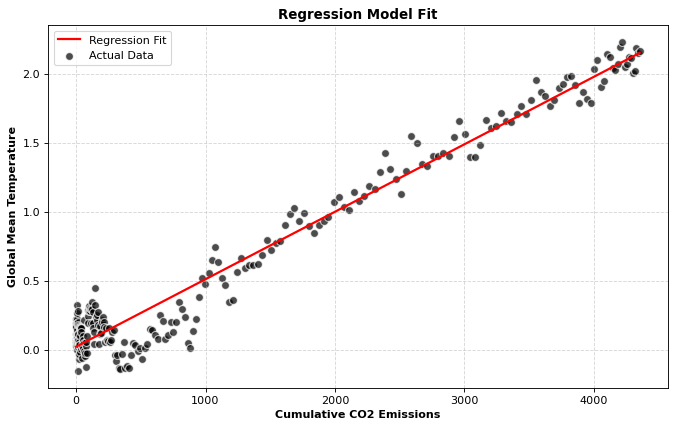

In [65]:
# Fitting the model
model.fit(X, y)

# Make predictions
predicted_temperatures = model.predict(X)

# The 'predicted_temperatures' array now contains the model's prediction for each input data point
# Plot global mean temperature as a function of cumulative CO2 emissions
plt.figure(figsize=(10, 6), dpi=80)

# Plot the actual data points
plt.scatter(X, y, color='black', label='Actual Data', alpha=0.7, edgecolors='w', s=50) 

# Plot the regression fit
plt.plot(X, predicted_temperatures, color='red', label='Regression Fit', linewidth=2)

# axis labels and title
plt.xlabel('Cumulative CO2 Emissions', fontsize=10, fontweight='bold')
plt.ylabel('Global Mean Temperature', fontsize=10, fontweight='bold')
plt.title('Regression Model Fit', fontsize=12, fontweight='bold')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Optimize font sizes for the legend and use a frame
plt.legend(fontsize=10, frameon=True)

# Show the plot
plt.show()

Plot gobal mean temperature as a function of year, along with the regression fit

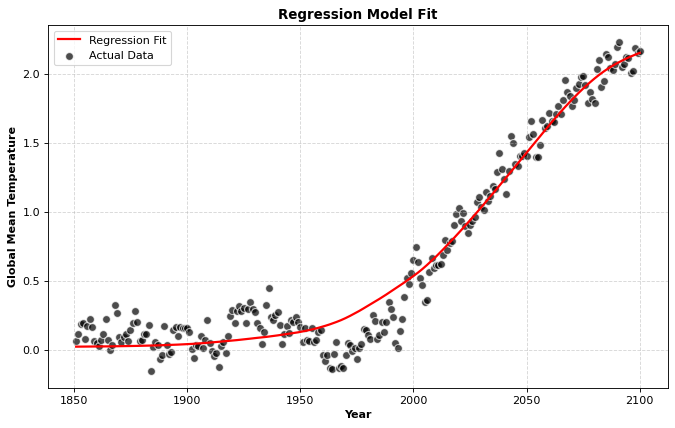

In [66]:
#similarly for year
X = final_df['year'].to_numpy().reshape(-1,1)  

# The 'predicted_temperatures' array now contains the model's prediction for each input data point
# Plot global mean temperature as a function of cumulative CO2 emissions
plt.figure(figsize=(10, 6), dpi=80)

# Plot the actual data points
plt.scatter(X, y, color='black', label='Actual Data', alpha=0.7, edgecolors='w', s=50) 

# Plot the regression fit
plt.plot(X, predicted_temperatures, color='red', label='Regression Fit', linewidth=2)

# axis labels and title
plt.xlabel('Year', fontsize=10, fontweight='bold')
plt.ylabel('Global Mean Temperature', fontsize=10, fontweight='bold')
plt.title('Regression Model Fit', fontsize=12, fontweight='bold')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Optimize font sizes for the legend and use a frame
plt.legend(fontsize=10, frameon=True)

# Show the plot
plt.show()

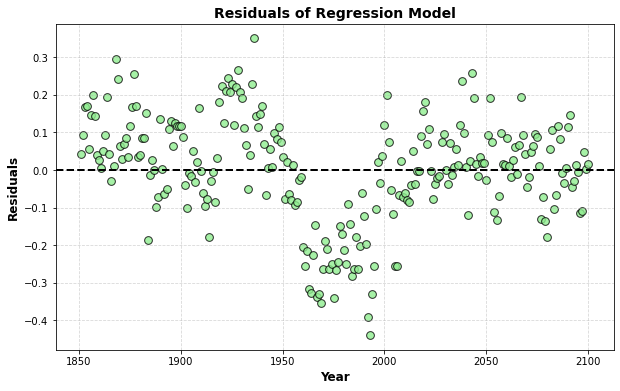

In [67]:
#since residual is the difference between actual and predicted values
residuals = y - predicted_temperatures

# Increase the figure size
plt.figure(figsize=(10, 6))

# Plot the residuals against cumulative CO2 emissions
plt.scatter(X, residuals, color='lightgreen', alpha=0.8, edgecolors='k', s=60)  # 's' is the size of the marker

# Draw a horizontal line at zero to indicate no residual
plt.axhline(0, color='black', linewidth=2, linestyle='--')

# Label the axes and the plot
plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Residuals', fontsize=12, fontweight='bold')
plt.title('Residuals of Regression Model', fontsize=14, fontweight='bold')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()

## 4. Extend this to a regional temperature model, by region, and by state

Now, I’ll extend the model to predict regional temperature changes. While global temperature shows a fairly linear relationship with cumulative CO2 emissions, regional temperature trends are more complex. This complexity arises because regional temperatures are influenced by factors like the distribution of land and ocean and the geographical spread of CO2 emissions. Despite this, I'll explore how well our model can capture regional variations.

To begin, I’ll load the country mask, a 2D array aligned with the temperature data grid, where each cell contains the country code corresponding to that region. This will allow us to break down the temperature changes by country and region.

In [50]:
country_mask_file = 'country_mask.nc'
country_mask = xr.open_dataarray(country_mask_file)
country_mask

<xarray.DataArray (lat: 96, lon: 144)>
[13824 values with dtype=<U24]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

Average the spatial coordinates into countries so that you end up with a dataset that has dimensionality of the number of countries by the number of time points.

In [51]:
# Load the temperature data
temperature_data = xr.open_dataset('global_temparature.nc')

# Assign the country mask to the temperature data as a non-dimension coordinate
temperature_data = temperature_data.assign_coords(country=((['lat','lon']),country_mask.data))
global_temp = temperature_data.groupby('country').mean()
global_temp

<xarray.Dataset>
Dimensions:   (time: 250, country: 150)
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9
  * country   (country) object 'Afghanistan' 'Albania' ... 'Zambia' 'Zimbabwe'
Data variables:
    tas       (country, time) float32 0.3524 0.2306 0.5797 ... 3.522 3.409 3.674

Plot a bar chart of the warming in each country in 2023. Note, the temperature data is baselined to 1850.

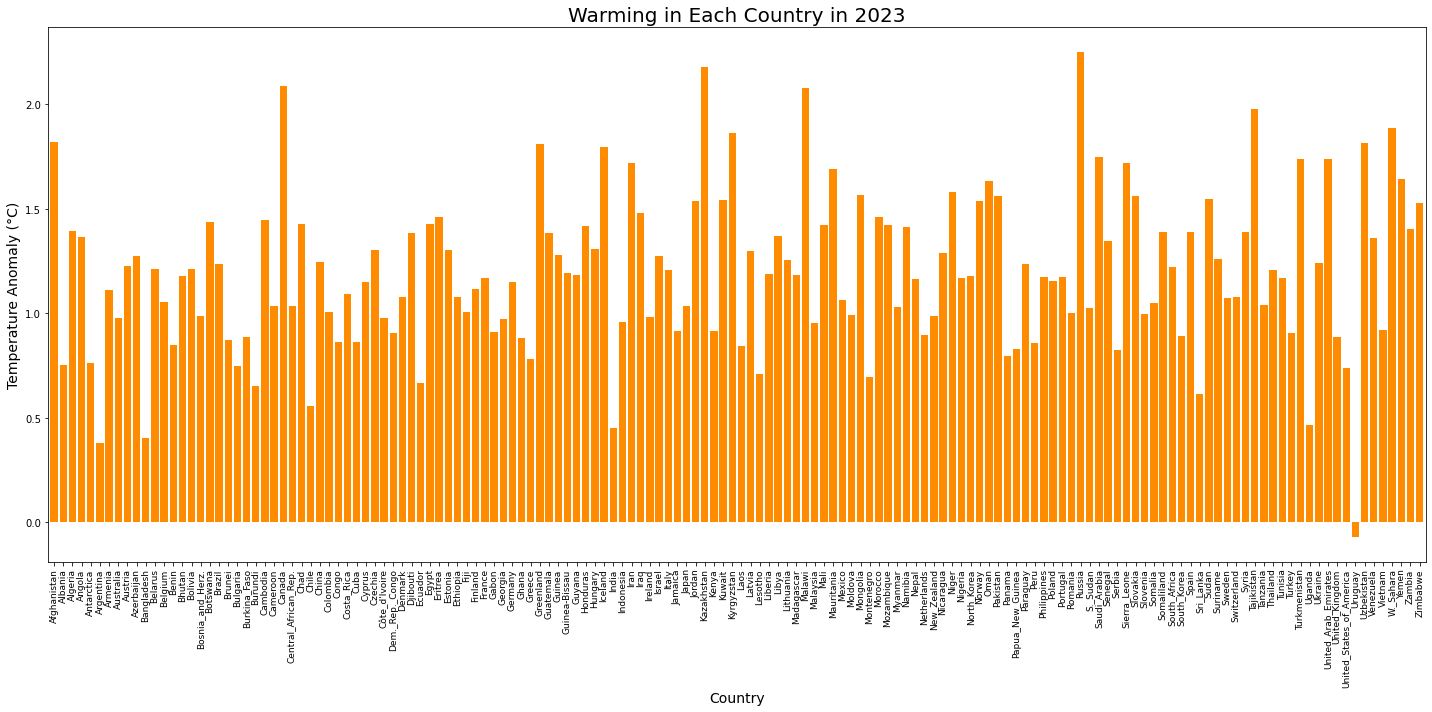

In [68]:
data_2023 = global_temp['tas'].sel(time=2023)

# Convert to a pandas Series
series_2023 = data_2023.to_series()

# Set the figure size
plt.figure(figsize=(20, 10))

# Create the bar chart
ax = series_2023.plot.bar(width=0.8, color ='darkorange')

# Set the title and labels
ax.set_title('Warming in Each Country in 2023', fontsize=20)
ax.set_xlabel('Country', fontsize=14)
ax.set_ylabel('Temperature Anomaly (°C)', fontsize=14)

# Rotate x-axis labels
ax.set_xticklabels(series_2023.index, rotation=90, ha='center', fontsize=9)

# Ensure all x-axis labels are shown
plt.xticks(range(len(series_2023.index)), series_2023.index)

# Ensure layout fits the plot and labels
plt.tight_layout()

# Display the plot
plt.show()

Calculate a linear regression model for each country along with the R^2 value. Plot the R^2 values for each country as a bar chart.

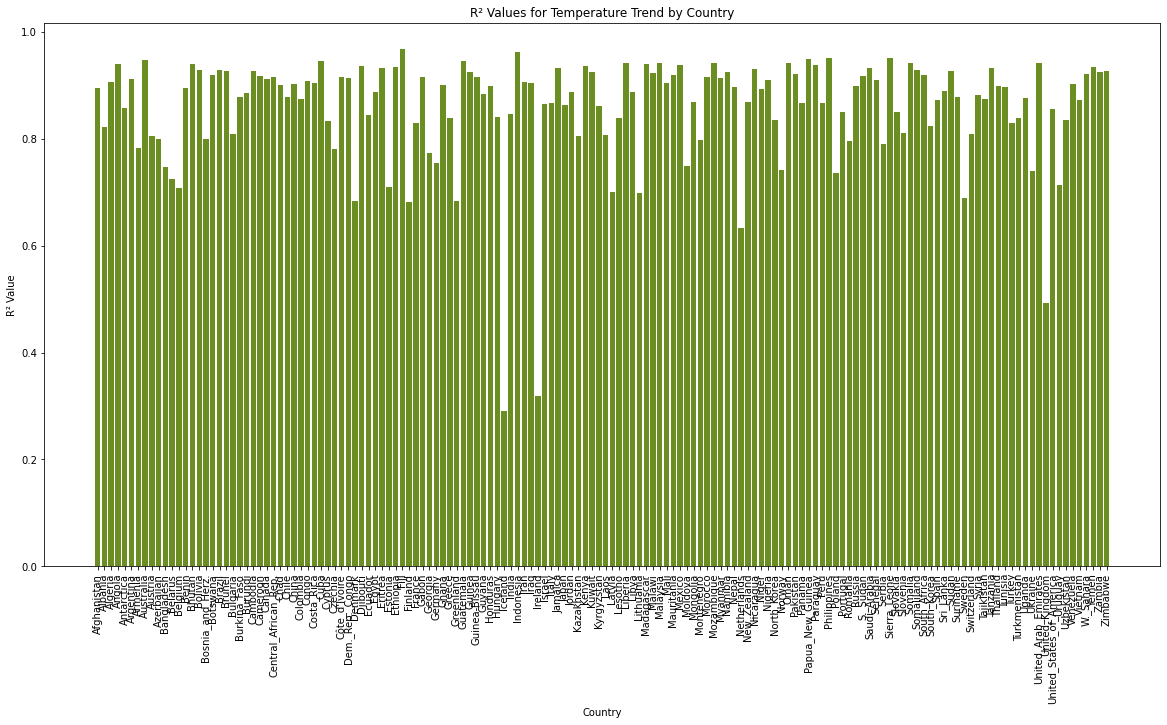

In [69]:
r2_values = {}

# Iterate over each country
for country in global_temp['tas'].country.values:
    # Extract the temperature timeseries for this country
    temp_timeseries = global_temp['tas'].sel(country=country)
    
    # Prepare the data for fitting the model (X should be 2D array, y should be 1D array)
    X = final_df['cumulative_CO2'].values.reshape(-1, 1)  # Time as 2D array
    y = temp_timeseries.values  # Temperature as 1D array
    
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate the R² value and store it
    r2_values[country] = model.score(X, y)

# Convert the R² values to a format suitable for plotting, e.g., a list
countries = list(r2_values.keys())
r2_scores = list(r2_values.values())

# Plotting the R² values as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(countries, r2_scores, color='olivedrab')
plt.xlabel('Country')
plt.ylabel('R² Value')
plt.title('R² Values for Temperature Trend by Country')
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.show()

In this analysis, I explore which countries align well with the linear model assumption and which do not.

Countries with bars reaching the top of the chart (close to an R² value of 1) are those where the linear model fits well. For these countries, temperature changes over time can be effectively modeled using a simple linear function. Examples include Malawi and New Zealand, where the linear assumption holds strong, with R² values above 0.7.

Conversely, countries with shorter bars (R² values significantly lower than 1, especially closer to 0) show that the linear assumption does not capture the full complexity of temperature changes. This is likely due to factors such as variable climate patterns, geographic features, or other regional influences that aren't accounted for in a linear model. Examples of countries where the linear model works less well include Iceland and Ireland, along with many European countries, where R² values drop below 0.3, suggesting more variability and the need for a more complex model.

## 5. Plot the regression coefficients for each country


In this section, I will plot the regression coefficients for each country to identify which ones are most sensitive to CO2 emissions and thus warming the fastest. The regression coefficient represents the rate at which temperature increases with respect to cumulative CO2 emissions. By examining the top five countries with the highest coefficients, we can pinpoint those that are experiencing the most rapid warming due to CO2 emissions.

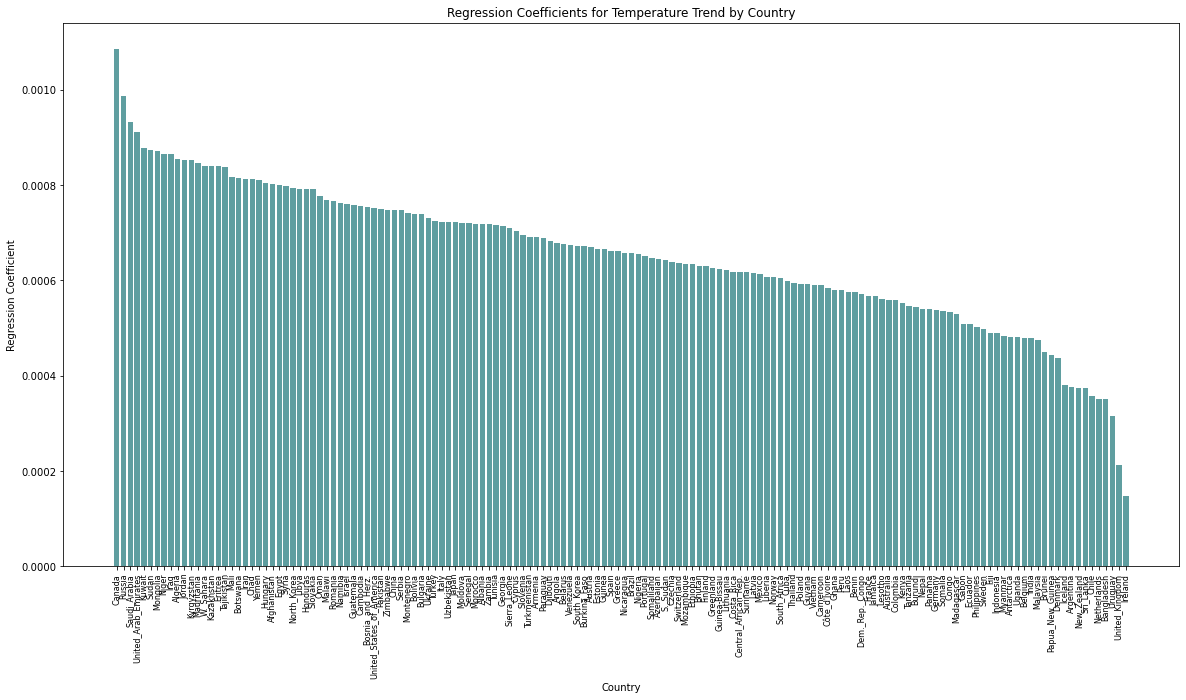

Top five countries most sensitive to CO2 emissions: ['Canada', 'Russia', 'Saudi_Arabia', 'United_Arab_Emirates', 'Kuwait']


In [54]:
coefficients = {}

# Iterate over each country to compute the regression coefficients
for country in global_temp['tas'].country.values:
    
    X = final_df['cumulative_CO2'].values.reshape(-1, 1)  # Time as a 2D array for the regression model
    y = global_temp['tas'].sel(country=country).values  # Temperature data

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Store the coefficient for the country
    coefficients[country] = model.coef_[0]
    
# Plot the coefficients
countries = list(coefficients.keys())
coeffs = list(coefficients.values())

# Sort the countries by the absolute value of their coefficients, descending
sorted_countries = sorted(countries, key=lambda x: abs(coefficients[x]), reverse=True)

# # Sort the coefficients according to the sorted countries
sorted_coeffs = [coefficients[country] for country in sorted_countries]

# Plotting the coefficients
plt.figure(figsize=(20, 10))
plt.bar(sorted_countries, sorted_coeffs, color='cadetblue')
plt.xlabel('Country')
plt.ylabel('Regression Coefficient')
plt.title('Regression Coefficients for Temperature Trend by Country')
plt.xticks(rotation=90, fontsize=8)
plt.show()

# Identify the five countries with the largest absolute coefficients
top_countries = sorted_countries[:5]
print("Top five countries most sensitive to CO2 emissions:", top_countries)

###### We see that Canada, Russia, Saudi Arabia, United Arab Emirates, and Kuwait, and are hence warming the fastest.

## 6. Do an analysis of your choosing

In this section, I have the freedom to explore any aspect of the data that interests me. I could choose to focus on the temperature trends of a specific country, examine how temperature variability has changed over time, or even assess the likelihood of exceeding critical temperature thresholds in different regions

#### 6A. Doing a comparitive study of the temperature trends between any two countries.

For my analysis, I’ll be conducting a comparative study of temperature trends between two countries. This will involve looking at how temperature patterns have evolved over time in each country, identifying similarities or differences, and analyzing the factors that may contribute to any observed trends. This comparison will help highlight the impacts of CO2 emissions on different regions and provide insights into regional variability in climate change.

###### 1. Russia vs Greece

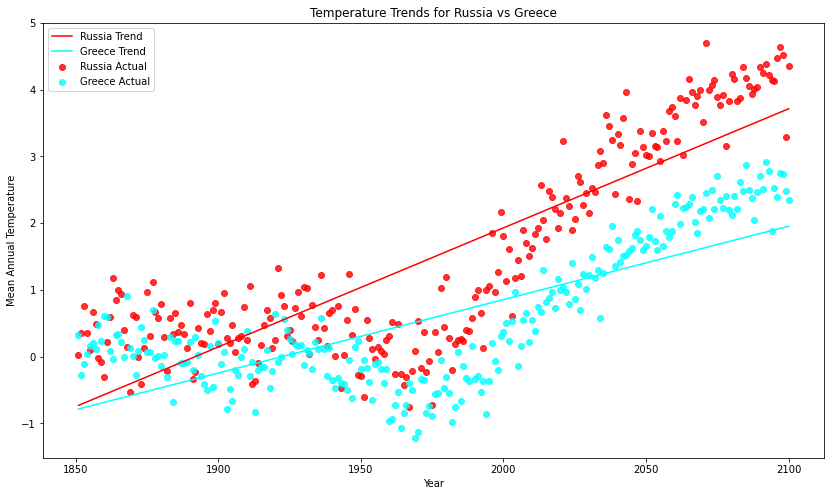

Standard Deviation of Annual Temperature for Russia: 1.5188943147659302
Standard Deviation of Annual Temperature for Greece: 1.0536165237426758
Temperature trend (slope) for Russia: 0.017854940883080716
Temperature trend (slope) for Greece: 0.011006778509366771


In [55]:
# Select two countries for comparison
country1 = 'Russia'
country2 = 'Greece'

# Calculate annual mean temperatures for each country over all dimensions
annual_mean_temp_country1 = global_temp['tas'].sel(country=country1).groupby('time').mean(...)
annual_mean_temp_country2 = global_temp['tas'].sel(country=country2).groupby('time').mean(...)

# Prepare the data for regression models
years = np.array(annual_mean_temp_country1.time)
X = years.reshape(-1, 1)

# Temperature trends using linear regression
model_country1 = LinearRegression().fit(X, annual_mean_temp_country1)
model_country2 = LinearRegression().fit(X, annual_mean_temp_country2)

# Calculate the temperature variability (standard deviation)
std_dev_country1 = annual_mean_temp_country1.std(dim='time')
std_dev_country2 = annual_mean_temp_country2.std(dim='time')

# Plotting the trends
plt.figure(figsize=(14, 8))
plt.plot(years, model_country1.predict(X), label=f'{country1} Trend', color = 'red')
plt.plot(years, model_country2.predict(X), label=f'{country2} Trend', color = 'cyan')
plt.scatter(years, annual_mean_temp_country1, label=f'{country1} Actual', alpha=0.8, color = 'red')
plt.scatter(years, annual_mean_temp_country2, label=f'{country2} Actual', alpha=0.8, color = 'cyan')
plt.xlabel('Year')
plt.ylabel('Mean Annual Temperature')
plt.title('Temperature Trends for Russia vs Greece')
plt.legend()
plt.show()

# Print out the variability for both countries
print(f"Standard Deviation of Annual Temperature for {country1}: {std_dev_country1.values}")
print(f"Standard Deviation of Annual Temperature for {country2}: {std_dev_country2.values}")

# Print out the slope (temperature trend) for both countries
print(f"Temperature trend (slope) for {country1}: {model_country1.coef_[0]}")
print(f"Temperature trend (slope) for {country2}: {model_country2.coef_[0]}")

######  Notably, Russia's temperature rise is more pronounced than Greece's, as evidenced by the steeper slope of its trend line. This suggests that Russia is experiencing a faster rate of temperature increase. The scatter of actual temperature data points around the trend lines reflects annual variability, with Russia showing a wider spread, possibly due to a more diverse climate or geographical variations

###### 2. India vs USA

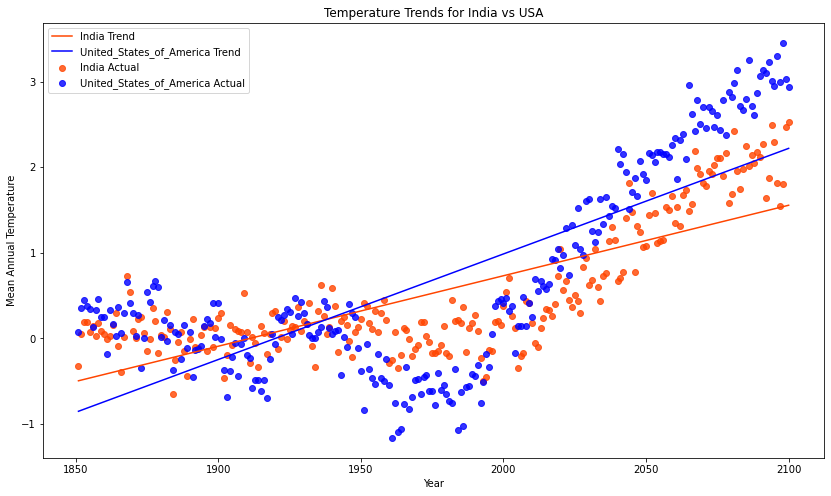

Standard Deviation of Annual Temperature for India: 0.7596064209938049
Standard Deviation of Annual Temperature for United_States_of_America: 1.186508297920227
Temperature trend (slope) for India: 0.008238855264452121
Temperature trend (slope) for United_States_of_America: 0.012340226140776159


In [56]:
# Select two countries for comparison
country1 = 'India'
country2 = 'United_States_of_America'

# Calculate annual mean temperatures for each country
annual_mean_temp_country1 = global_temp['tas'].sel(country=country1).groupby('time').mean(...)
annual_mean_temp_country2 = global_temp['tas'].sel(country=country2).groupby('time').mean(...)

# Prepare the data for regression models
years = np.array(annual_mean_temp_country1.time)
X = years.reshape(-1, 1)

# Temperature trends using linear regression
model_country1 = LinearRegression().fit(X, annual_mean_temp_country1)
model_country2 = LinearRegression().fit(X, annual_mean_temp_country2)

# Calculate the temperature variability (standard deviation)
std_dev_country1 = annual_mean_temp_country1.std(dim='time')
std_dev_country2 = annual_mean_temp_country2.std(dim='time')

# Plotting the trends
plt.figure(figsize=(14, 8))
plt.plot(years, model_country1.predict(X), label=f'{country1} Trend' , color = 'orangered')
plt.plot(years, model_country2.predict(X), label=f'{country2} Trend', color = 'blue')
plt.scatter(years, annual_mean_temp_country1, label=f'{country1} Actual', alpha=0.8, color = 'orangered')
plt.scatter(years, annual_mean_temp_country2, label=f'{country2} Actual', alpha=0.8, color = 'blue')
plt.xlabel('Year')
plt.ylabel('Mean Annual Temperature')
plt.title('Temperature Trends for India vs USA')
plt.legend()
plt.show()

# Print out the variability for both countries
print(f"Standard Deviation of Annual Temperature for {country1}: {std_dev_country1.values}")
print(f"Standard Deviation of Annual Temperature for {country2}: {std_dev_country2.values}")

# Print out the slope (temperature trend) for both countries
print(f"Temperature trend (slope) for {country1}: {model_country1.coef_[0]}")
print(f"Temperature trend (slope) for {country2}: {model_country2.coef_[0]}")

##### The trend lines suggest that while both countries are following an upward trajectory, the rate of increase is not identical. The United States shows a steeper ascent in recent years compared to India, indicating a more rapid warming. The actual temperature data points display variability but follow the general direction of the trend lines, which also forecast a continued rise in temperatures moving towards the year 2100.

#### 6B. Plotting the changes in variability of temperature

##### In this analysis, I’ll use the standard deviation as a measure to track changes in the variability of temperature between two key periods: the Industrial era (1850-1900) and the more recent period (1970-2020). Standard deviation helps quantify how much temperature values deviate from the mean, giving us insights into how much more (or less) variable temperatures have become over time. By comparing these two periods, I aim to highlight shifts in temperature stability and assess the impact of industrialization and CO2 emissions on temperature variability.

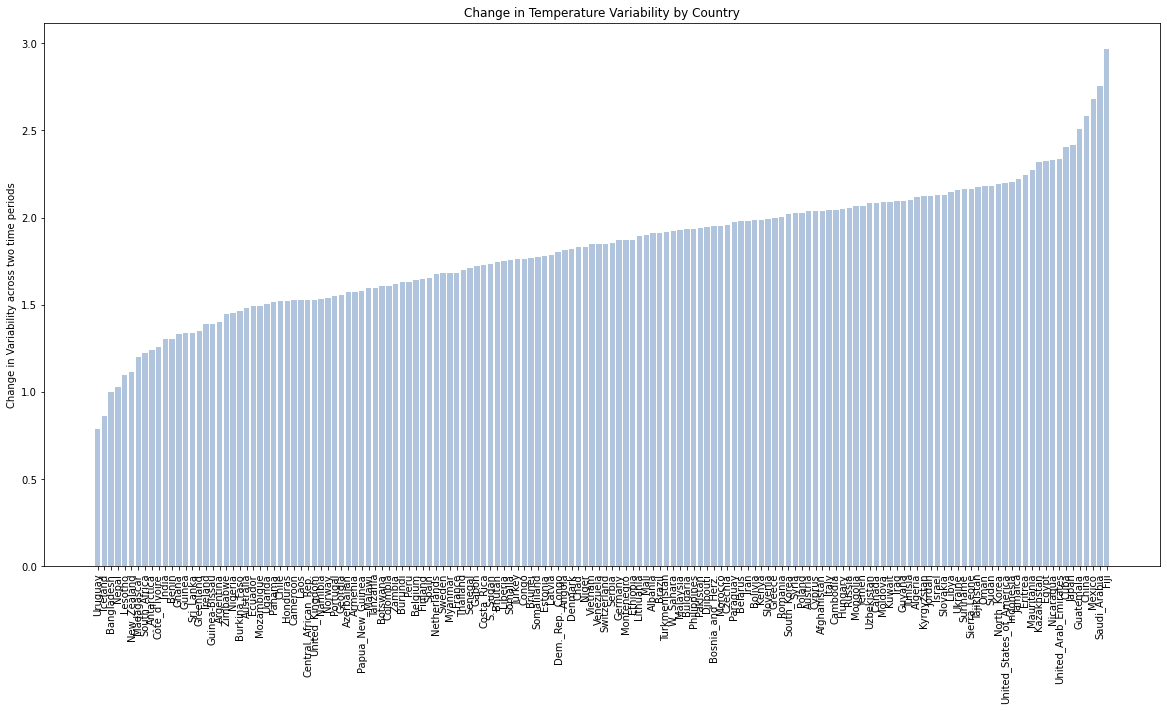

In [70]:
#assuming industrial period to be between 1850-1900, and modern period to be 1970-2020
early_industrial_period = slice('1850', '1900')  
current_period = slice('1970', '2020')  

# Calculate the standard deviation for the early industrial period
std_early = global_temp['tas'].sel(time=early_industrial_period).groupby('country').std(dim='time')

# Calculate the standard deviation for the current period
std_current = global_temp['tas'].sel(time=current_period).groupby('country').std(dim='time')

# You can convert the DataArray to a pandas DataFrame for easier manipulation if you like
df_std_early = std_early.to_dataframe().reset_index()
df_std_current = std_current.to_dataframe().reset_index()

# Now you have two dataframes with the standard deviation for each country in each period
# You can merge them and compare the values
df_comparison = pd.merge(df_std_early, df_std_current, on='country', suffixes=('_early', '_current'))

df_comparison
# Assuming you want to see the relative change in standard deviation
df_comparison['variability_change'] = df_comparison['tas_current'] / df_comparison['tas_early']


import matplotlib.pyplot as plt

# Make sure to sort the values if you want an ordered plot
df_comparison_sorted = df_comparison.sort_values('variability_change', ascending=True)

# Plotting
plt.figure(figsize=(20,10))
plt.bar(df_comparison_sorted['country'], df_comparison_sorted['variability_change'], color = 'lightsteelblue')
plt.xticks(rotation=90)  # Rotate the country names for better readability
plt.ylabel('Change in Variability across two time periods')
plt.title('Change in Temperature Variability by Country')
plt.show()


##### The countries on the left side of the chart show the least change in variability, while those on the right show the most, with Fiji having the highest increase in temperature variability. This suggests that while all the countries listed have experienced changes in temperature variability, the degree of change is not uniform across them. Countries with higher bars are experiencing greater fluctuations in temperature, which could have significant implications for their climate patterns, agricultural cycles, and overall environmental stability. The chart underscores that climate change impacts are not uniform and can vary greatly even at a national level.

## 7. Make a command line interface to a prediction script 

In this step, I'll create a command-line interface (CLI) that allows users to input a country name (or opt for a global mean) along with CO2 concentration values. The script will then predict the temperature change relative to 1850 based on these inputs. To handle this, I'll use the argparse package, and you can check the documentation here. I'll also ensure to validate inputs to avoid errors.

Additionally, I'll offer an option to save the predicted results into a CSV file for easy record-keeping.

To make the predictions efficient, this script will utilize the regression coefficients I calculated earlier, so there’s no need to run the full model each time. These coefficients can be stored in a numpy file, a pandas CSV file, or even a JSON file for quick access and computation.

In [58]:
#creating a pandas dataframe from the sorted countries and respective sorted coeffiecients to save as csv for the .py for CLI
sorted_list = list(zip(sorted_countries, sorted_coeffs))
sorted_df = pd.DataFrame(sorted_list, columns = ['country', 'coefficients'])
sorted_df.to_csv('Regression_coefficients.csv')

##### Snippet of the CLI.py file

In [ ]:
import argparse
import pandas as pd

df = pd.read_csv('Regression_coefficients.csv')


def create_parser():
    parser = argparse.ArgumentParser(description="Predict temperature change based on country and CO2 concentration.")
    parser.add_argument("country", type=str, help="Name of the country")
    parser.add_argument("co2_concentration", type=float, help="CO2 concentration level")
    parser.add_argument("--save_csv", action="store_true", help="Option to save the predictions to a CSV file")
 
    return parser

# Function to perform the prediction
def predict_temperature_change(df, country, co2_concentration):
    # Extract the coefficient for the given country
    # Check if the country exists in the dataframe
    if country not in df['country'].values:
        return "Country not found in the dataframe."
    else:
        # If the country is not found, return an error message
        coeff = df.loc[df['country'] == country, 'coefficients'].iloc[0]
        return coeff * co2_concentration

# Main function to parse arguments and execute the prediction
def main(args=None):
    # Set a flag to indicate whether the program should proceed with saving to CSV
    flag = True
    
    # Create an argument parser using the helper function create_parser()
    parser = create_parser()
    
    # Parse the command-line arguments
    args = parser.parse_args(args)
    try:
        prediction = predict_temperature_change(df, args.country, args.co2_concentration)
        if (prediction == "Country not found in the dataframe."):
            # If the country is not found, print the error message and set the flag to False
            print(prediction)
            flag = False
        else:
            # If the prediction is successful, print the predicted temperature change
            print(f"The predicted temperature change for {args.country} with a CO2 concentration of {args.co2_concentration} is {prediction}")
    except ValueError as e:
        # If there's a ValueError (e.g., wrong type of arguments), print the error message
        print(e)
        
    if flag and args.save_csv:
        # Create a DataFrame with the prediction results
        predictions_df = pd.DataFrame({'Country': [args.country], 'CO2 Concentration': [args.co2_concentration], 'Predicted Temperature Change': [prediction]})
        predictions_df.to_csv('/home/rchatterjee/FinalProject/predictions.csv', index=False)
        print("Predictions saved to predictions.csv")
# Call the main function to execute the script
main()

In [71]:
#running the command
!python3 CLI.py India 347 --save_csv

The predicted temperature change for India with a CO2 concentration of 347.0 is 0.1663470170332327
Predictions saved to predictions.csv


In [72]:
#Checking the output

saved_file = pd.read_csv('predictions.csv')
saved_file

,Country,CO2 Concentration,Predicted Temperature Change
0,India,347.0,0.166347


In [ ]:
#another example
!python3 CLI.py Kuwait 6587 